# ExplainableRL: Onboarding recipe
Pricing strategy can hugely influence a company's profitability, and therefore understanding price sensitivity and market demand is essential. With ExplainableRL, we have automated the manual process of pricing strategies using reinforcement learning. We have overcome the limitations of popular RL libraries such as Mushroom RL by creating an environment capable of dealing with industry datasets, and an explainability framework to understand the automated decisions.

This notebook presents a comprehensive guide on utilizing ExplainableRL. It outlines the necessary steps, including the selection of environment, training of preferred agent, performance evaluation, generation of PDP plots and SHAP values to aid in understanding the agent's decision-making, and an overview of the time and memory performance of the primary processing components of the library. A more detailed overview of ExplainableRL can be found in the documentation.


### Relevant imports

In [2]:
from library import *

# Import functions
from src.foundation.engine import Engine
from src.data_handler.data_handler import DataHandler
from src.explainability.pdp import PDP
from src.explainability.shap_values import ShapValues
from src.foundation import utils

### 1. Parameters Setting

In [3]:
# TODO: Explain each parameter and when to use what
hyperparam_dict_ds_data_predict = {
    "dimensions": {'states': {'lead_time': 10,
                                'length_of_stay': 10,
                                'competitor_price_difference_bin': 4,
                                'demand_bin': 4},
                    'actions': {'price': 10},
                    'rewards': ['reward']
                    },

    "dataset": {'data_path': 'data/ds-data/my_example_data.parquet',
                'col_delimiter': '|',
                'n_samples': 100000,
                'normalisation': True},

    "training": {'env_type': 'strategic_pricing_predict',
                    'num_episodes': 10,
                    'num_steps': 1,
                    'train_test_split': 0.2,
                    'evaluate': False,
                    'num_eval_steps': 3000},

    "agent": {'agent_type': 'q_learner',
                "gamma": 0.3,
                "epsilon": 0.1,
                "epsilon_decay": 0.05,
                "epsilon_minimum": 0.01,
                "learning_rate": 0.1,
                "learning_rate_decay": 0.05,
                "learning_rate_minimum": 0.01,
                "lambda": 0.2,
                "use_uncertainty": False,
                "q_importance": 0.7,
                },

    "explainability": {'shap_num_samples': 1},

    "program_flow": {"verbose": False}
}

### 2. Initialisation

In [4]:
# TODO: overview of what to initialise (DataHandler & Engine with Agent and Env inside)
# TODO: If needed by evaluation/explainability/performance add a new dictionary and explain it
hyperparam_dict = hyperparam_dict_ds_data_predict


#### 2.a. Data Loading

Load dataset and split it:

In [5]:
dataset = utils.load_data(hyperparam_dict['dataset']['data_path'], hyperparam_dict['dataset']['n_samples'])
train_dataset, test_dataset = utils.split_train_test(dataset)

#### 2.b. Datahandler Initialisation

In [6]:
# TODO: Add explanation

dh = DataHandler(hyperparam_dict=hyperparam_dict, dataset=train_dataset, test_dataset=test_dataset)


#### 2.b. Engine Initialisation

In [16]:
# TODO: Add explanation

engine = Engine(dh=dh, hyperparam_dict=hyperparam_dict)


#### 2.c. Environment and Agent Initialisation

In [17]:
engine.create_world()

### 3. Agent Training and Saving

In [9]:
# TODO: Add explanation

#### 3.a. Training

In [18]:
# TODO: Add explanation
engine.train_agent()

100%|██████████| 10/10 [00:00<00:00, 297.01it/s]


#### 3.b. Saving Engine

In [11]:
# TODO: Add explanation

utils.save_engine(engine, path_name='runs/engine_q_learner_1.pkl')


#### 3.c Load Engine from Checkpoint

In [12]:
# TODO: Add explanation

engine = utils.load_engine(path_name='runs/engine_q_learner_1.pkl')

### 4. Agent Evaluation

Import Evaluator class. The Evaluator class provides custom Reinforcement Learning Plots (such as cumulative reward per episode, or average reward distribution) averaged across different runs. It also provides other metrics such as: total agent reward versus historical reward on the test set, or action accuracy versus historical data.

In [13]:
from src.evaluation.evaluator import Evaluator

evaluator = Evaluator(engines = [engine])

Evaluate cumulative reward on test set using historical vs learnt agent policy:

In [15]:
print(f"Historical baseline: {evaluator.hist_cum_rewards()}")
print(f"Agent Policy: {evaluator.agent_cum_rewards()}")

Historical baseline: 144517.08682381466
Agent Policy: 151389.90566518463


Plot cumulative reward versus training episode:

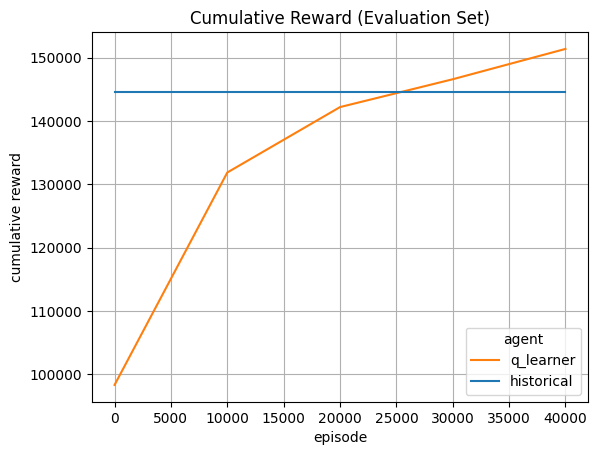

In [16]:
evaluator.plot_training_curve()

Plot average reward distribution:

saving figure


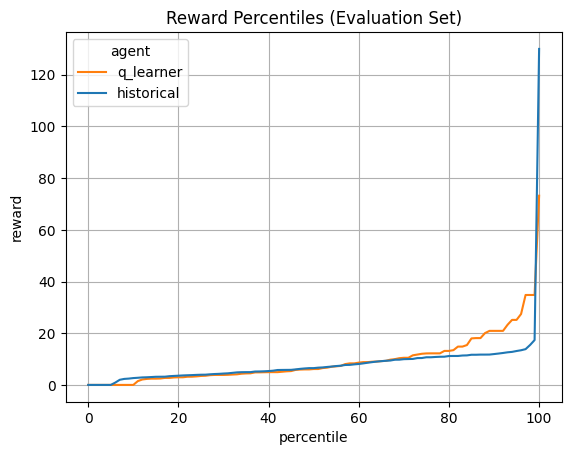

In [17]:
evaluator.plot_reward_distribution()

### 5. Explainability

In [ ]:
# TODO: Add explanation on explainability framework

#### 5.a. PDP Plots

In [ ]:

# TODO: Add explanation
if verbose:
    timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    print(f"{timestamp}: Show PDPs plots")
pdp = PDP(engine=engine)
pdp.build_data_for_plots(engine.agent.Q, engine.agent.Q_num_samples)
type_features = hyperparam_dict['feature_types']
fig_name = "PDP plots - All states"
pdp.plot_pdp(states_names=state_labels, 
             fig_name=fig_name,
             type_features=type_features, 
             savefig=True, 
             all_states=True)
# TODO: Change PDP parameters based on new parameters dictionary

#### 5.b. Shap Values

In [ ]:
# TODO: Add explanation
if verbose:
    timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    print(f"{timestamp}: Show SHAP values plots")
shap_values = ShapValues(sample=[8, 1, 1, 1],
                         engine=engine,
                         number_of_samples=shap_num_samples)
shaps, predicted_action = shap_values.compute_shap_values()
print(shaps)
print(predicted_action)
# TODO: Change SHAP parameters based on new parameters dictionary

### 6. Performance

In [ ]:
# TODO: Add explanation
# Explain how to run the performance and what all the results mean

### 7. Documentation

In [ ]:
# TODO: Add explanation
# Explain how to access documentation in the browser